## Week Three Assignment - Graph Visualization
### This week's assignment is to:
#### 1. Load a graph database of your choosing from a text file or other source. If you take a large network dataset from the web (such as from https://snap.stanford.edu/data/), pleasefeel free at this point to load just a small subset of the nodes and edges.
#### 2. Create basic analysis on the graph, including the graph’s diameter, and at least one other metric of your choosing. You may either code the functions by hand (to build your intuition and insight), or use functions in an existing package.
#### 3. Use a visualization tool of your choice (Neo4j, Gephi, etc.) to display information.
#### 4. Please record a short video (~ 5 minutes), and submit a link to the video as part of your homework submission. You may work in a small group on this project. Parts one and two should be posted to GitHub and submitted in your assignment link by end of day September 12th. Parts 3 and 4 should be in your video presentation.

## Step 1: Importing a graph network of my choise from https://snap.stanford.edu/data/.
####  I selected a subset from the 'Cisco Networks' data from: https://snap.stanford.edu/data/cisco-networks.html
#### This raw download has about 22 different graphs within it, so just selecting one for the purpose ofthis exercise. 
#### According to the read me, for the 20 different graphs in the "dir_20_graphs_ folder, the edges in these tet files are from four different days in two different months and the data is dumped for a number of hours of data. So for this were taking the data in the first chunk of the first day. 

In [1]:
import networkx as nx
from collections import defaultdict
import matplotlib.pyplot as plt


### initial Path : CiscoSecureWorkload_22_networks\Cisco_22_networks\dir_20_graphs\dir_day1\out1_1.txt
## Mnually moved a copy more locally 
pathway = r"out1_1.txt"

In [2]:
### Titles of the components from the read me:
# graph, client node id, server node id, csv of port, protocol, and number of packets.
### Line one of thechunk im using: 
# g1	1	2	1p6-22,1p17-4,2p6-12,3p6-12,4p6-12,5p6-12


In [3]:
## Function aimed at parsing out the additional information from that fourth column. 
def parse_services(services_str):
    """
    Input example:
        '1p6-22,1p17-4,2p6-12'
    
    Output:
        A list of dictionaries, one per service observation:
        [
          {'port': 1, 'protocol': 6, 'packets': 22},
          {'port': 1, 'protocol': 17, 'packets': 4},
          ...
        ]
    """
    
    services = []  # This will hold the parsed service records
    
    # Split the string on commas to separate each service entry
    for token in services_str.split(","):
        
        # Split on '-' to separate "port+protocol" from "packet count"
        left, packet_count = token.split("-")
        
        # Split on 'p' to separate port number and protocol number
        port, protocol = left.split("p")
        
        # Convert all numeric fields from strings to integers
        services.append({
            "port": int(port),
            "protocol": int(protocol),
            "packets": int(packet_count)
        })
    
    return services


In [4]:
### ingesting and parsing the entire file from the outline path
parsed_rows = []  # This will hold all parsed rows from the file

# Open the file in read mode
with open(pathway, "r") as file:
    
    # Loop over each line in the file
    for line in file:
        
        # Remove leading/trailing whitespace (including newline)
        line = line.strip()
        
        # Skip empty lines
        if not line:
            continue
        
        # Skip comment lines (README says comments start with '#')
        if line.startswith("#"):
            continue
        
        # Split the line on whitespace (tabs or spaces both work)
        graph_id, client_id, server_id, services_str = line.split()
        
        # Convert node IDs from strings to integers
        client_id = int(client_id)
        server_id = int(server_id)
        
        # Parse the 4th column using our function
        services = parse_services(services_str)
        
        # Store everything in a structured dictionary
        parsed_rows.append({
            "graph": graph_id,
            "client": client_id,
            "server": server_id,
            "services": services
        })


In [5]:
## Confirming that the raw text data was parsed correctly by the code

print(len(parsed_rows)) ## Same number as the number of lines in the file. Good Sign.


## Taking the frist row to confirm parsing
print(parsed_rows[0])
### Raw Line:
# g1	1	2	1p6-22,1p17-4,2p6-12,3p6-12,4p6-12,5p6-12



566835
{'graph': 'g1', 'client': 1, 'server': 2, 'services': [{'port': 1, 'protocol': 6, 'packets': 22}, {'port': 1, 'protocol': 17, 'packets': 4}, {'port': 2, 'protocol': 6, 'packets': 12}, {'port': 3, 'protocol': 6, 'packets': 12}, {'port': 4, 'protocol': 6, 'packets': 12}, {'port': 5, 'protocol': 6, 'packets': 12}]}


In [6]:
### looks like it worked fine. 
parsed_rows

[{'graph': 'g1',
  'client': 1,
  'server': 2,
  'services': [{'port': 1, 'protocol': 6, 'packets': 22},
   {'port': 1, 'protocol': 17, 'packets': 4},
   {'port': 2, 'protocol': 6, 'packets': 12},
   {'port': 3, 'protocol': 6, 'packets': 12},
   {'port': 4, 'protocol': 6, 'packets': 12},
   {'port': 5, 'protocol': 6, 'packets': 12}]},
 {'graph': 'g2',
  'client': 1,
  'server': 2,
  'services': [{'port': 1, 'protocol': 6, 'packets': 625}]},
 {'graph': 'g2',
  'client': 3,
  'server': 4,
  'services': [{'port': 1, 'protocol': 17, 'packets': 4}]},
 {'graph': 'g1',
  'client': 3,
  'server': 4,
  'services': [{'port': 6, 'protocol': 6, 'packets': 38},
   {'port': 7, 'protocol': 6, 'packets': 92},
   {'port': 8, 'protocol': 6, 'packets': 37},
   {'port': 9, 'protocol': 6, 'packets': 26},
   {'port': 10, 'protocol': 6, 'packets': 113},
   {'port': 11, 'protocol': 6, 'packets': 33},
   {'port': 12, 'protocol': 6, 'packets': 160},
   {'port': 13, 'protocol': 6, 'packets': 165},
   {'port': 14

In [7]:
### Putting it into a Graph DB
# graphs_dict will map: "g1" -> DiGraph, "g2" -> DiGraph, ...
graphs_dict = defaultdict(nx.DiGraph)

for row in parsed_rows:
    gid = row["graph"]          # e.g., 'g1'
    u = row["client"]           # source (client)
    v = row["server"]           # target (server)

    # total packets across all port/protocol entries for this edge
    total_packets = sum(s["packets"] for s in row["services"])

    # get the correct NetworkX graph for this graph id
    G = graphs_dict[gid]

    # if this edge already exists, add to its weight; otherwise create it
    if G.has_edge(u, v):
        G[u][v]["weight"] += total_packets
    else:
        G.add_edge(u, v, weight=total_packets)

# Example: pick one graph and inspect it
G1 = graphs_dict["g1"]
print("g1 nodes:", G1.number_of_nodes(), "edges:", G1.number_of_edges())
print(list(G1.edges(data=True))[:5])

g1 nodes: 945 edges: 85205
[(1, 2, {'weight': 74}), (1, 359, {'weight': 118}), (1, 183, {'weight': 437705}), (1, 433, {'weight': 82}), (1, 349, {'weight': 80})]


## Step 2: Base Level Analysis of the Graph Chart including the Graph Diameter. 

In [8]:
### Taking the Graph chart ingested were going to calculate the:

### Total number of nodes in this graph db

print("Number of Nodes in G1: ", G1.number_of_nodes())

### Total number of edges
print("Number of Edges in G1: ", G1.number_of_edges())

### Does this graph have direction?
print ("Does this graph db have direction (a directed graph db): ", isinstance(G1, nx.DiGraph))

### Number of Connected Components:
g1_undir = G1.to_undirected()
con_comp = list(nx.connected_components(g1_undir))
print("Number of connected components:", len(con_comp))

## THE largest Connected components of the graph
largest_cc_nodes = max(con_comp, key=len)

#### Graph Density ( The number of actual edges compared ot the total number of *possible* edges.)
print("Density of the graph: ",round(nx.density(G1),4))
print(f"This means roughly {100*round(nx.density(G1),4)}% of all possible connections are made.")

#### Graph Diameter (The Closest that the two furthest nodes are in the graph Db)
# Getting the subgraph of only connected nodes.
subset = g1_undir.subgraph(largest_cc_nodes).copy()
print("The graph diameter, looking at the connected components, is: ", nx.diameter(subset))


Number of Nodes in G1:  945
Number of Edges in G1:  85205
Does this graph db have direction (a directed graph db):  True
Number of connected components: 10
Density of the graph:  0.0955
This means roughly 9.55% of all possible connections are made.
The graph diameter, looking at the connected components, is:  8


## Step 3: Visualization a Graph with tool of choice 

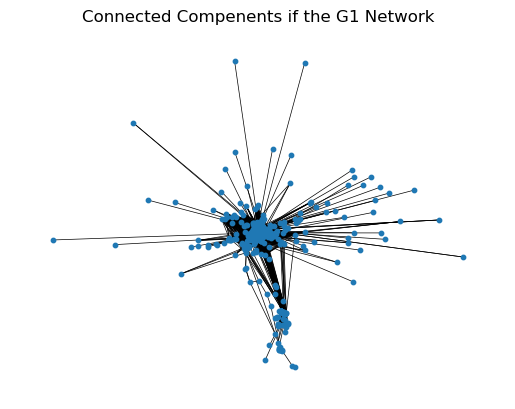

In [16]:
### Making the visualization of the subset generated previously for the conected components of the data.
sprng = nx.spring_layout(subset, seed=42)
nx.draw_networkx_nodes(subset,sprng, node_size=10)
nx.draw_networkx_edges(subset,sprng,  width=0.5)
plt.title("Connected Compenents if the G1 Network Graph DB")
plt.axis("off")
plt.show()

In [17]:
### Explorting the Graph DB for Viewing with Gephi for Part 3
nx.write_gexf(G1, "g1_network.gexf")

## Step 4: Video Documenting my actions 